In [32]:
# Importing liberaries

import pandas as pd
import numpy as np
from ast import literal_eval  # evaluate strings containing Python code in the current Python environment
from nltk.stem.snowball import SnowballStemmer # Removing stem words
from sklearn.feature_extraction.text import CountVectorizer  # To convert text to numerical data
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from collections import defaultdict
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
import seaborn as sns
import networkx as nx

import warnings  # disable python warnings
warnings.filterwarnings("ignore")

import tkinter as tk
import tkinter.ttk
from tkinter import *
import tkinter.messagebox

In [33]:
# Loading datasets

movies_data = pd.read_csv("dataset/movies_metadata.csv", low_memory=False)
credits = pd.read_csv('dataset/credits.csv')
keywords = pd.read_csv('dataset/keywords.csv')
links_small = pd.read_csv('dataset/links_small.csv')
ratings = pd.read_csv("dataset/ratings_small.csv")

In [34]:
# Removing the rows with null value in the vote_average and vote_count columns in movies_data dataframe

movies_data = movies_data.dropna(subset=['vote_average', 'vote_count'])

In [35]:
def weighted_rating(v,R):

    '''

    This function calculate weighted rating of a movies using IMDB formula

    Parameters: v (int): vote count
                R (int): vote average
    Returns: (float) IMDB score

    '''
    return ((v/(v+m)) * R) + ((m/(m+v)) * C)



C = movies_data['vote_average'].mean()         # mean vote across all data
m = movies_data['vote_count'].quantile(0.95)   # movies with more than 95% votes is taken (95 percentile)

# Taking movies whose vote count is greater than m
top_movies = movies_data.copy().loc[movies_data['vote_count'] >= m]
top_movies = top_movies.reset_index()

top_movies['score'] = ''

for i in range(top_movies.shape[0]):
    v = top_movies['vote_count'][i]          # number of vote count of the movie
    R = top_movies['vote_average'][i]        # average rating of the movie
    top_movies['score'][i] = weighted_rating(v,R)

top_movies = top_movies.sort_values('score', ascending=False)  # sorting movies in descending order according to score
top_movies = top_movies.reset_index()

# top_movies[['title', 'vote_count', 'vote_average', 'score']].head(20) # top 20 movies
t1 = top_movies[['title', 'score']].head(20)

In [36]:
genres = set()

# Finding the exhaustive set of genres in the dataset
top_movies['genres'] = top_movies['genres'].apply(literal_eval)
for i in range(top_movies['genres'].shape[0]):   # converting string in map
    for x in top_movies['genres'][i]:
        genres.add(x['name'])


# creating map of string (genre name) and movies names(dataframe)
genres_based = dict()
for i in range(top_movies['genres'].shape[0]):
    for x in top_movies['genres'][i]:
        if x['name'] not in genres_based.keys():
            genres_based[x['name']] = pd.DataFrame(columns = top_movies.columns)
        genres_based[x['name']] = genres_based[x['name']].append(top_movies.iloc[i])

In [12]:
# Creating a count vector (list) containing frequency of a perticular genre
cnt = list()
for i in genres:
    cnt.append(genres_based[i].shape[0])

# Making a datafram
genre_cnt = pd.DataFrame( { 'genres' : list(genres),
                            'count'  : cnt

},
                         columns = ['genres','count']
)

In [37]:
def genres_based_rcmnd(name):

    '''

    This function returns the top 10 movies of the given genre

    Parameters: name (string): Name of the genre

    Returns: (Dataframe) Top 10 move recommendation

    '''

    if name not in genres:
        return None
    else:
        return genres_based[name][['title', 'vote_count', 'vote_average', 'score']].head(10)

In [38]:
#Preprocessing the data

movies_data['id'] = movies_data['id'].astype('int')  #The astype() function is used to cast a pandas object to a specified data type.

# merging both credits and keywords in movies_data on the basis of movie id
movies_data = movies_data.merge(credits, on='id')
movies_data = movies_data.merge(keywords, on='id')

links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

# taking only those movies whos id is present in link_small because of limited computing power
smd = movies_data[movies_data['id'].isin(links_small)]
smd = smd.reset_index()

In [39]:
def get_director(x):

    '''

    This function gives the name of first director occuring in the crew of the movie

    Parameters: x(list of dictionary): List containing name and corrosponding role of complete cast of the movie

    Returns: (string) It returns the first director name that appear in the list

    '''

    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan


# Applying literal_eval to get the right data type from the expression of string
smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['genres'] = smd['genres'].apply(literal_eval)

smd['director'] = smd['crew'].apply(get_director)

# Taking all the movie cast in a list and then taking only the top 3 cast
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])# Strip Spaces and Convert to Lowercase

smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

smd['genres'] = smd['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['genres'] = smd['genres'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x,x])  # giving more weight to the director relative to the entire cast

In [40]:
def filter_keywords(x):

    '''

    This funtion remove those keywords which occur only once

    Parameters: x(list): List containing keywords of the movie

    Returns: (list) It returns a list containg only those keywords which are present in keywords_count ( it is a dictionary containg those keywords which occur more than once )

    '''

    words = []
    for i in x:
        if i in keywords_count.keys():
            words.append(i)
    return words


# Creating the count of every keywords
keywords_count = dict()
for i in range(len(smd['keywords'])):
    for j in range(len(smd['keywords'][i])):
        if smd['keywords'][i][j] not in keywords_count.keys():
            keywords_count[smd['keywords'][i][j]] = 0
        keywords_count[smd['keywords'][i][j]] +=1

# removing those keywords which occur only once
for i in list(keywords_count):
    if keywords_count[i] == 1:
        del keywords_count[i]

In [41]:
# preprocessing

# Stemming the words
stemmer = SnowballStemmer('english')

smd['keywords'] = smd['keywords'].apply(filter_keywords) # removing those keywords which occur only once
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])

# combining keywords, cast, director and genres
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))

(-0.5, 399.5, 199.5, -0.5)

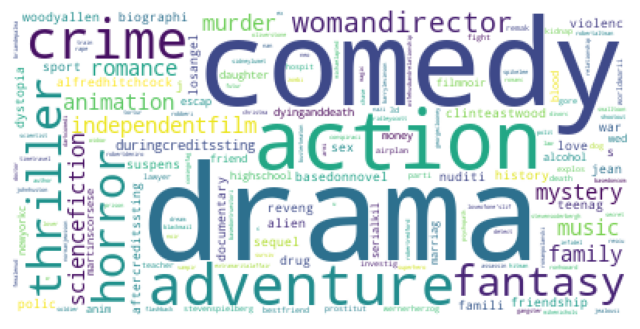

In [42]:
# Creating the Wordcloud for visualisation of the word which occur frequently in the dataset

# Combining all the text contained in smd['soup'] column
text = ""
for i in smd['soup']:
    text +=i

word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud
# plot the WordCloud image
plt.figure(figsize = (8, 8))
plt.imshow(word_cloud)
plt.axis("off")

In [43]:
count = CountVectorizer(analyzer='word',ngram_range=(1, 2) ,min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])

cosine_sim = cosine_similarity(count_matrix, count_matrix)

titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])  # Creating a mapping between movie and title and index

In [44]:
df_cosine=pd.DataFrame(cosine_sim)

In [ ]:
def get_recommendations(title):

    '''

    This function gives the top 10 movies according to the cosine similarities calculated above along with the movie id

    Parameters: title (string) : Name of the movie present in the smd dataset

    Returns: (list) Top 10 movies along with the movie id


    '''

    idx = indices[title] # movie id corrosponding to the given title
    sim_scores = list(enumerate(cosine_sim[idx])) # list of cosine similarity scores value along the given index
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) # sorting the given scores in ascending order
    sim_scores = sim_scores[1:31] # Taking only the top 30 scores
    movie_indices = [i[0] for i in sim_scores] # Finding the indices of 30 most similar movies
    return titles.iloc[movie_indices]

In [46]:
# drop the timestamp column since we dont need it now
ratings = ratings.drop(columns="timestamp")

#checking for missing values
ratings.isna().sum()

#check for the numbers of total movies and users
movies= ratings['movieId'].nunique()  #nunique is similar to count but only takes unique values
users=ratings['userId'].nunique()

In [47]:
# columns to use for training
columns = ['userId','movieId','rating']

# create reader from surprise
# the rating should lie in the provided scale
reader = Reader(rating_scale =(0.5,5))

#create dataset from dataframe
data = Dataset.load_from_df(ratings[columns],reader)

# create trainset ie the data which is present (ratings of those movies which are rated by respective users)
trainset = data.build_full_trainset()

# create testset, here the anti_testset is testset
# data containing users movie pairs which are not rated by that particular user
testset = trainset.build_anti_testset()


model = SVD(n_epochs = 25, verbose = True) #n_epochs:The number of iteration of the SGD(simple gradient descent) procedure. Default is 20
                                           #verbose:If True, prints the current epoch. Default is False.

cross_validate(model, data, measures=['RMSE','MAE'], cv= 5, verbose= True)
print('Training Done')

#prediction
prediction = model.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

In [48]:
example = { 'userId' : [99999,99999,99999,99999,99999],
           'movieId' : [31,1029,1293,1172,1343],
           'rating'  : [3.0, 4.5, 1.2, 3.3,2]

}

df = pd.DataFrame(example)
frames = [ratings, df]
result = pd.concat(frames)

In [49]:
#create dataset from dataframe
data= Dataset.load_from_df(result[columns],reader)

#create trainset
trainset= data.build_full_trainset()

#create testset, here the anti_testset is testset
testset = trainset.build_anti_testset()

cross_validate(model,data, measures=['RMSE','MAE'], cv= 5, verbose= True) #cv is the number of parts in which data will be divided.
print('Training Done')

#prediction
prediction = model.test(testset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

In [50]:
def get_top_n(prediction, n):

    '''
    This function recommend users with top n movies based on prediction calculated using the surprise library

    Parameters: prediction(list): This contains (user, movie) rating prediction for all user movie pairs
                n(int): Number of recommendations

    Results: Returns top 30 movies along with movie id for all users


    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in prediction:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the n highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

rcmnd = []
top_n = get_top_n(prediction, n=30)
for uid, user_ratings in top_n.items():
    if uid == 99999:
        for (iid,rating) in user_ratings:
            for i in range(movies_data.shape[0]):
                if movies_data['id'][i] == iid:
                    rcmnd.append([movies_data['id'][i],movies_data['title'][i]])
        break

In [51]:

l = [None for i in range(10)]

def genre_based():
    '''
       Callback function used for the submit button on the interface

       This function takes input directly from the Tkinter interface and based on the type of input provided it finds recommendation for the user and provide output on the Tkinter interface.

       Parameters: None

       Returns: None

    '''

    for i in range(10):
        if l[i] is not None:
            l[i].grid_remove()
    event = clicked.get()

    # produced recommendations for the user based on the rating provided to selected movies if no genre is selected else recommend top movies from the selected genres
    if event == "Select Genre":
        rtts = list()
        rtts.append(l11.get())
        rtts.append(l12.get())
        rtts.append(l13.get())
        rtts.append(l14.get())
        rtts.append(l15.get())
        movie_ratings = [int(i) for i in rtts]
        print(movie_ratings)

        example = { 'userId' : [99999,99999,99999,99999,99999],
           'movieId' : [278, 13,637,122, 11],
           'rating'  : movie_ratings,
                  }

        df = pd.DataFrame(example)
        frames = [ratings, df]
        result = pd.concat(frames)

        #create dataset from dataframe
        data= Dataset.load_from_df(result[columns],reader)

        #create trainset
        trainset= data.build_full_trainset()

        #create testset, here the anti_testset is testset
        testset = trainset.build_anti_testset()

        cross_validate(model,data, measures=['RMSE','MAE'], cv= 5, verbose= True)
        print('Training Done')

        #prediction
        prediction = model.test(testset)
        prediction[99999]

        # An RMSE value of less than 2 is considered good
        #Now Recommend Users top 10 movies based on prediction

        from collections import defaultdict
        def get_top_n(prediction, n):

            # First map the predictions to each user.
            top_n = defaultdict(list)
            for uid, iid, true_r, est, _ in prediction:
                top_n[uid].append((iid, est))

            # Then sort the predictions for each user and retrieve the n highest ones.
            for uid, user_ratings in top_n.items():
                user_ratings.sort(key=lambda x: x[1], reverse=True)
                top_n[uid] = user_ratings[:n]

            return top_n

        rcmnd = []
        top_n = get_top_n(prediction, n=30)
        for uid, user_ratings in top_n.items():
            if uid == 99999:
                for (iid,rating) in user_ratings:
                    for i in range(movies_data.shape[0]):
                        if movies_data['id'][i] == iid:
                            rcmnd.append([movies_data['id'][i],movies_data['title'][i]])
                break

        for i in range(min(10,len(rcmnd))):
            l[i] = Label(root ,  text = rcmnd[i][1])
            l[i].grid(row = 2+i, column = 5, sticky = W, pady = 5)
    else:
        ll = list((genres_based[event][['title']].head(10))['title'])
        for i in range(min(10,len(ll))):
            l[i] = Label(root ,  text = ll[i])
            l[i].grid(row = 2+i, column = 5, sticky = W, pady = 5)

In [52]:
# temp dataframe contains movies which are present in both ratings and movies_data dataframe

id_list = list(ratings['movieId'])
temp = movies_data.loc[movies_data['id'].isin(id_list)]
temp = temp.reset_index()
print(temp[['id' , 'title']])
temp['title'][1]

         id                       title
0       949                        Heat
1       710                   GoldenEye
2      1408            Cutthroat Island
3       524                      Casino
4      4584       Sense and Sensibility
...     ...                         ...
2843  80831                Sang Pemimpi
2844   3104  Frankenstein Created Woman
2845  64197        Travelling with Pets
2846  98604                  Cinderella
2847  49280            The One-Man Band

[2848 rows x 2 columns]


'GoldenEye'

In [53]:
# This snippet is used to find top ranked movies according to imdb score which are present in temp dataframe.

available_movies = []

for movie in list(t1['title']):
    movie = movie.lower()
    for i in range(temp.shape[0]):
        name = temp['title'][i].lower()
        if name == movie:
            available_movies.append((temp['id'][i] , movie))

print(available_movies)

[(278, 'the shawshank redemption'), (238, 'the godfather'), (155, 'the dark knight'), (550, 'fight club'), (680, 'pulp fiction'), (13, 'forrest gump'), (424, "schindler's list"), (129, 'spirited away'), (1891, 'the empire strikes back'), (637, 'life is beautiful'), (240, 'the godfather: part ii'), (122, 'the lord of the rings: the return of the king'), (101, 'leon: the professional'), (510, "one flew over the cuckoo's nest"), (497, 'the green mile'), (11, 'star wars')]


In [54]:
# create root window
root = Tk()

# root window title and dimension4
root.title("Recommender System")

# Set geometry (widthxheight)
root.geometry('1000x400')

''

In [55]:
# Dropdown menu options
options = [
    'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'TV Movie',
 'Thriller',
 'War',
 'Western'
]

# adding a label to the root window
l1 = Label(root, text = "MOVIE RECOMMENDER SYSTEM", fg = "blue")
l1.grid(row = 0,column = 1)
l2 = Label(root, text = "Select genre of the movie you want to watch : ")
l2.grid(row = 1,column = 0,sticky = W, pady = 2)

# datatype of menu text
clicked = StringVar()

# initial menu text
clicked.set( "Select Genre" )

# Create Dropdown menu
drop = OptionMenu( root , clicked , *options)
drop.grid(row = 3,column = 0, sticky = W)

# Creating seperators for better UI
x1 = tkinter.ttk.Separator(root, orient=VERTICAL).grid(column=1, row=1, rowspan=12, sticky='ns')

l3 = Label(root, text = "Rate the following movies")
l3.grid(row = 1,column = 2,sticky = W, pady = 2)

# labels for movies name
l4 = Label(root, text="Movies Name").grid(row=2, column=2)
l5 = Label(root, text="the shawshank redemption").grid(row=3, column=2) # 278
l6 = Label(root, text="forest gump").grid(row=4, column=2) # 13
l7 = Label(root, text="life is beautiful").grid(row=5, column=2) #637
l8 = Label(root, text="the lord of the rings: the return of the king").grid(row=6, column=2) #122
l9 = Label(root, text="star wars").grid(row=7, column=2) # 11

# label for movies rating
l10 = Label(root, text="Rate the movie on the scale of 5").grid(row=2, column=3)
l11 = Spinbox(root, from_= 0, to = 5)
l11.grid(row=3, column=3)
l12 = Spinbox(root, from_= 0, to = 5)
l12.grid(row=4, column=3)
l13= Spinbox(root, from_= 0, to = 5)
l13.grid(row=5, column=3)
l14 = Spinbox(root, from_= 0, to = 5)
l14.grid(row=6, column=3)
l15 = Spinbox(root, from_= 0, to = 5)
l15.grid(row=7, column=3)


# button widget with green color text
button = Button(root, text = "SUBMIT" , fg = "white",bg = "green", command = genre_based)
button.grid(row = 9,column = 1, sticky = S)

# Creating seperators for better UI
x2 = tkinter.ttk.Separator(root, orient=VERTICAL).grid(column=4, row=1, rowspan=12, sticky='ns')

l16 = Label(root, text="Results").grid(row=1, column= 5, sticky = W, pady=10)

In [59]:
# start the program
root.mainloop()